In [1]:
%load_ext autoreload
%autoreload 2
 
%matplotlib inline

from __future__ import absolute_import, division, print_function
import timeit
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.DEBUG)
import matplotlib.pyplot as plt
import random
import shutil
from collections import defaultdict

from scipy.integrate import cumtrapz

from PIL import Image
import imageio
from cStringIO import StringIO

import cPickle as pickle

import sys
sys.path.append("../code")
from st_graph import hps
from stg_node import STGNode
from utils.learning import _SUPER_SECRET_EVAL_KEY
from experiment_details import NUM_DATAFILES, ROWS_TO_EXTRACT, EDGE_RADIUS, EDGE_STATE_COMBINE_METHOD, EDGE_INFLUENCE_COMBINE_METHOD

/Users/borisi/anaconda2/envs/proactive/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
robot_stg_node = STGNode('Al Horford', 'HomeC')
robot_node = str(robot_stg_node)

# Creating Videos

### Loading Models

In [3]:
from glob import glob
from st_graph import *
from data_utils import *
from stg_node import *

tf.reset_default_graph()

In [4]:
positions_map_path = "data/positions_map.pkl"
pos_dict_path = "data/pos_dict_eval_%d_files_%d_rows.pkl" % (NUM_DATAFILES, ROWS_TO_EXTRACT)

with open(pos_dict_path, 'rb') as f:
    pos_dict = pickle.load(f)

STG = SpatioTemporalGraphCVAE(pos_dict, robot_stg_node,
                              edge_radius=EDGE_RADIUS,
                              edge_state_combine_method=EDGE_STATE_COMBINE_METHOD,
                              edge_influence_combine_method=EDGE_INFLUENCE_COMBINE_METHOD)

train_data_dict_path = "data/train_data_dict_%d_files_%d_rows.pkl" % (NUM_DATAFILES, ROWS_TO_EXTRACT)
with open(train_data_dict_path, 'rb') as f:
    train_data_dict = pickle.load(f)

eval_data_dict_path = "data/eval_data_dict_%d_files_%d_rows.pkl" % (NUM_DATAFILES, ROWS_TO_EXTRACT)
with open(eval_data_dict_path, 'rb') as f:
    eval_data_dict = pickle.load(f)

hps.add_hparam("nodes_standardization", eval_data_dict["nodes_standardization"])
hps.add_hparam("extras_standardization", {"mean": eval_data_dict["extras_mean"],
                                          "std": eval_data_dict["extras_std"]})
hps.add_hparam("labels_standardization", eval_data_dict["labels_standardization"])
hps.add_hparam("pred_indices", eval_data_dict["pred_indices"])
        
eval_input_function = tf.estimator.inputs.numpy_input_fn(eval_data_dict["input_dict"],
                                                         y = eval_data_dict["labels"],
                                                         batch_size = 4,
                                                         num_epochs = 1,
                                                         shuffle = False)

In [5]:
# Can use the below to short-cut the saved model creation after you've run P2 at least once.
saved_eval_predictive_model_231 = "models/eval_models/1522209405"
# saved_eval_predictive_model_781 = "models/eval_models/1519905263"
saved_eval_predictive_model = saved_eval_predictive_model_231

In [6]:
tf.reset_default_graph()
with tf.Graph().as_default() as g:
    sess = tf.Session()
    print("Loading model from: " + saved_eval_predictive_model)
    tf.saved_model.loader.load(sess,
                               [tf.saved_model.tag_constants.SERVING],
                               saved_eval_predictive_model)

Loading model from: models/eval_models/1522209405
INFO:tensorflow:Restoring parameters from models/eval_models/1522209405/variables/variables


In [7]:
eval_data_dict = {str(k): v for k, v in eval_data_dict['input_dict'].iteritems()}

### Making Videos

In [8]:
# This keeps colors consistent across timesteps, rerun this cell if you want to reset the colours.
color_dict = defaultdict(dict)

In [9]:
import matplotlib.patheffects as pe

def plot_predictions(eval_data_dict, sess,
                     num_samples=100, data_id=0, t_predict=20,
                     radius_of_influence=EDGE_RADIUS, focus_on=None,
                     focus_window_height=6, line_alpha=0.7, 
                     line_width=0.2, edge_width=2, circle_edge_width=0.5,
                     only_predict=None,
                     dpi=300, fig_height=7,
                     ylim=(0, 50), xlim=(0, 100),
                     return_frame=False, printing=False,
                     robot_circle=True, 
                     robot_shift_future=0.0, robot_shift='x',
                     add_legend=True, title=None,
                     flip_axes=False, omit_names=False,
                     axes_labels=True, rotate_axes_text=0,
                     save_at=None):
    
    aspect_ratio = float(xlim[1] - xlim[0]) / (ylim[1] - ylim[0])
    figsize=(fig_height*aspect_ratio, fig_height)
    
    max_time = eval_data_dict[robot_node][data_id, :].shape[0]
    predict_horizon = hps.prediction_horizon
    
    if t_predict < hps.minimum_history_length:
        print('ERROR: t_predict must be >=', hps.minimum_history_length)
        return None
    elif t_predict + predict_horizon >= max_time:
        print('ERROR: t_predict must be <=', max_time - predict_horizon - 1)
        return None
    
    dt = 0.04 # 0.04 => 25 Hz.
    
    ###################
    ### Predictions ###
    ###################
    tic = timeit.default_timer()

    tic0 = timeit.default_timer()
    feed_dict = {k + ':0': v[[data_id]] for k, v in eval_data_dict.iteritems() if '/' in k}

    robot_future = eval_data_dict[robot_node][data_id : data_id+1, 
                                              t_predict + 1 : t_predict + predict_horizon + 1].copy()

    if robot_shift_future != 0.0:
        idx = 4 if robot_shift == 'x' else 5
        print('Shifting %s by %.2f!' % (robot_shift, robot_shift_future))
        robot_future[..., idx] += robot_shift_future
        robot_future[..., idx - 2] = cumtrapz(robot_future[..., idx], axis=1, initial=0, dx=dt) + robot_future[0, 0, idx - 2]
        robot_future[..., idx - 4] = cumtrapz(robot_future[..., idx - 2], axis=1, initial=0, dx=dt) + robot_future[0, 0, idx - 4]

    feed_dict[robot_node + "_future:0"] = robot_future

    feed_dict["traj_lengths:0"] = [t_predict]
    feed_dict["sample_ct:0"] = [num_samples]
    feed_dict["extras:0"] = eval_data_dict["extras"][[data_id]]
    toc0 = timeit.default_timer()

    if printing:
        print("constructing feed_dict took: ", toc0 - tic0, " (s), running tf!")

    run_list = list()
    for node_str in eval_data_dict:
        if '/' not in node_str or robot_node in node_str:
            continue
            
        if focus_on is not None and node_str != focus_on:
            continue

        run_list.extend([node_str + '_1/outputs/y:0',
                         node_str + '_1/outputs/z:0'])

    tic0 = timeit.default_timer()
    outputs = sess.run(run_list, feed_dict=feed_dict)
    toc0 = timeit.default_timer()

    if printing:
        print("done running tf!, took (s): ", toc0 - tic0)

    toc = timeit.default_timer()

    if printing:
        print("total time taken (s): ", toc - tic)
    
    ########################
    ### Data Preparation ###
    ########################
    prefixes_dict = dict()
    futures_dict = dict()
    for i in xrange(0, len(outputs), 2):
        node_name = run_list[i].split('_')[0]

        node_data = eval_data_dict[node_name]
        prefix_earliest_idx = max(0, t_predict - predict_horizon)
        prefixes_dict[node_name] = node_data[data_id : data_id+1, prefix_earliest_idx : t_predict + 1, 0:2]
        futures_dict[node_name] = node_data[data_id : data_id+1, t_predict + 1 : t_predict + predict_horizon + 1, 0:2]

    # 44.72 km/h = 40.76 ft/s (ie. that's the max value that a coordinate can be)
    max_speed = 40.76
    output_pos = dict()
    sampled_zs = dict()
    for i in xrange(0, len(outputs), 2):
        node_name = run_list[i].split('_')[0]

        # Ensuring vector magnitude is <= max_speed
        offending_indices = np.linalg.norm(outputs[i], axis=3) > max_speed
        num_offending = np.count_nonzero(offending_indices)
        if num_offending > 0:
#             print('WARNING! Had %d offending inputs!' % num_offending)
            dividing_factor = np.linalg.norm(outputs[i][offending_indices], axis=1, keepdims=True) / max_speed
            outputs[i][offending_indices] = outputs[i][offending_indices] / dividing_factor

        x_ = cumtrapz(outputs[i][..., 0], axis=2, initial=0, dx=dt) + futures_dict[node_name][0, 0, 0]
        y_ = cumtrapz(outputs[i][..., 1], axis=2, initial=0, dx=dt) + futures_dict[node_name][0, 0, 1]

        output_pos[node_name] = np.stack([x_, y_], axis=3)
        sampled_zs[node_name] = outputs[i + 1]
    
    if printing:
        print('prefixes_dict[node_name].shape', prefixes_dict[node_name].shape)
        print('futures_dict[node_name].shape', futures_dict[node_name].shape)
        print('output_pos[node_name].shape', output_pos[node_name].shape)
        print('sampled_zs[node_name].shape', sampled_zs[node_name].shape)
        
    ######################
    ### Visualizations ###
    ######################
    fig, ax = plt.subplots(figsize=figsize)
    not_added_prefix = True
    not_added_future = True
    not_added_samples = True
    for node_name in prefixes_dict:
        if focus_on is not None and node_name != focus_on:
            continue
        
        prefix = prefixes_dict[node_name][0]
        future = futures_dict[node_name][0]
        predictions = output_pos[node_name][:, 0]
        z_values = sampled_zs[node_name][:, 0]

        prefix_all_zeros = not np.any(prefix)
        future_all_zeros = not np.any(future)
        if prefix_all_zeros and future_all_zeros:
            continue
            
        if not (xlim[0] <= prefix[-1, 0] <= xlim[1]) or not (ylim[0] <= prefix[-1, 1] <= ylim[1]):
            continue
        
        # Prefix trails
        if not_added_prefix:
            ax.plot(prefix[:, 0], prefix[:, 1], 'k--', label='History')
            not_added_prefix = False
        else:
            ax.plot(prefix[:, 0], prefix[:, 1], 'k--')

        # Predicted trails
        if only_predict is None or (only_predict is not None and node_name == only_predict):
            if not_added_samples:
#                 plt.plot([] , [], 'r', label='Sampled Futures')
                not_added_samples = False
                
            for sample_num in xrange(output_pos[node_name].shape[0]):
                z_value = tuple(z_values[sample_num])
                if z_value not in color_dict[node_name]:
                    color_dict[node_name][z_value] = "#%06x" % random.randint(0, 0xFFFFFF)

                ax.plot(predictions[sample_num, :, 0], predictions[sample_num, :, 1], 
                        color=color_dict[node_name][z_value], 
                        linewidth=line_width, alpha=line_alpha)

        # Future trails
        if not_added_future:
            ax.plot(future[:, 0], future[:, 1], 'w--',
                    path_effects=[pe.Stroke(linewidth=edge_width, foreground='k'), pe.Normal()], label='Actual Future')
            not_added_future = False
        else:
            ax.plot(future[:, 0], future[:, 1], 'w--',
                path_effects=[pe.Stroke(linewidth=edge_width, foreground='k'), pe.Normal()])

        # Current Node Position
        circle = plt.Circle((prefix[-1, 0], prefix[-1, 1]), 0.3, 
                            facecolor='b' if 'Home' in node_name else 'g', 
                            edgecolor='k', lw=circle_edge_width,
                            zorder=3)
        ax.add_artist(circle)
        
#         if focus_on:
#             ax.set_title(node_name)
#         else:
#             ax.text(prefix[-1, 0] + 0.4, prefix[-1, 1], node_name, zorder=4)
        
        if not omit_names:
            ax.text(prefix[-1, 0] + 0.4, prefix[-1, 1], node_name, zorder=4)


    # Robot Node
    if focus_on is None:
        prefix_earliest_idx = max(0, t_predict - predict_horizon)
        robot_prefix = eval_data_dict[robot_node][data_id, prefix_earliest_idx : t_predict + 1, 0:2]
#         robot_future = eval_data_dict[robot_node][data_id, t_predict + 1 : t_predict + predict_horizon + 1, 0:2]
        robot_future = robot_future[0, :, 0:2].copy()

        prefix_all_zeros = not np.any(robot_prefix)
        future_all_zeros = not np.any(robot_future)
        if not (prefix_all_zeros and future_all_zeros) and ((xlim[0] <= robot_prefix[-1, 0] <= xlim[1]) 
                                                            and 
                                                            (ylim[0] <= robot_prefix[-1, 1] <= ylim[1])):
            ax.plot(robot_prefix[:, 0], robot_prefix[:, 1], 'k--')
            ax.plot(robot_future[:, 0], robot_future[:, 1], 'w--',
                    path_effects=[pe.Stroke(linewidth=edge_width, foreground='k'), pe.Normal()])

            circle = plt.Circle((robot_prefix[-1, 0], robot_prefix[-1, 1]), 0.3, 
                                facecolor='b' if 'Home' in robot_node else 'g', 
                                edgecolor='k', lw=circle_edge_width,
                                zorder=3)
            ax.add_artist(circle)

            # Radius of influence
            if robot_circle:
                circle = plt.Circle((robot_prefix[-1, 0], robot_prefix[-1, 1]), radius_of_influence, 
                                    fill=False, color='r', linestyle='--', zorder=3)
                ax.plot([], [], 'r--', label='Edge Radius')
                ax.add_artist(circle)

            if not omit_names:
                ax.text(robot_prefix[-1, 0] + 0.4, robot_prefix[-1, 1], robot_node, zorder=4)

    if focus_on is None:
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
    else:
        y_radius = focus_window_height
        x_radius = aspect_ratio*y_radius
        ax.set_ylim((prefix[-1, 1] - y_radius, prefix[-1, 1] + y_radius))
        ax.set_xlim((prefix[-1, 0] - x_radius, prefix[-1, 0] + x_radius))
    
    if add_legend:
        ax.legend(loc='upper left')
    
    if title is not None:
        ax.set_title(title)
    
    string_splitter = ' '
    if omit_names:
        string_splitter = '\n'
        
    if axes_labels:
        ax.set_xlabel('Longitudinal Court Position ($l$)')
        ax.set_ylabel('Lateral Court%sPosition ($w$)' % string_splitter)
        
    if rotate_axes_text != 0:
        plt.xticks(rotation=rotate_axes_text)
        plt.yticks(rotation=rotate_axes_text)
    
    fig.tight_layout()
    
    if return_frame:
        buffer_ = StringIO()
        plt.savefig(buffer_, format="png", transparent=True, dpi=dpi)
        buffer_.seek(0)
        data = np.asarray(Image.open( buffer_ ))
        
        plt.close(fig);
        return data
    
    if save_at is not None:
        plt.savefig(save_at, dpi=300, transparent=True)
    
    plt.show()
    plt.close(fig);

In [10]:
def make_video(eval_data_dict, sess, 
               num_samples=100, data_id=0, 
               t_from=5, t_to=25, 
               circle_edge_width=1.0, line_alpha=0.9, 
               only_predict=None,
               focus_window_height=4, 
               line_width=0.2, edge_width=2,
               fps=12, focus_on=None, 
               ylim=(0, 50), xlim=(0, 100),
               robot_circle=False,
               title='',
               fname='prediction_video.mp4'):
    
    max_time = eval_data_dict[robot_node][data_id, :].shape[0]
    print('max_time =', max_time)

    frames = list()
    for t_predict in xrange(t_from, t_to): #xrange(hps.minimum_history_length, max_time - hps.prediction_horizon):
        if t_predict % 10 == 0:
            print(t_predict)
        
        frame = plot_predictions(eval_data_dict, sess, 
                                 num_samples=num_samples, 
                                 data_id=data_id, 
                                 t_predict=t_predict, 
                                 circle_edge_width=circle_edge_width, 
                                 line_alpha=line_alpha, 
                                 only_predict=only_predict,
                                 focus_window_height=focus_window_height, 
                                 line_width=line_width, edge_width=edge_width,
                                 focus_on=focus_on, 
                                 ylim=ylim, xlim=xlim,
                                 robot_circle=robot_circle,
                                 title=title,
                                 return_frame=True);

        if frame is not None:
            frames.append(frame);
        else:
            break
    
    imageio.mimwrite(fname, frames, 
                     fps=fps, quality=10);

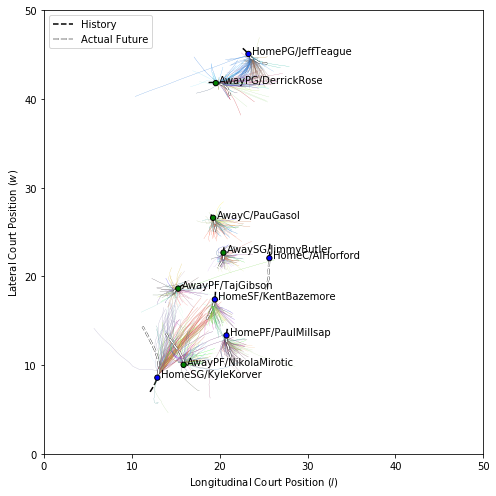

In [11]:
# 781
data_id = 7
only_predict = None#'AwayPF/NikolaMirotic'
ylim = (0, 50)
xlim = (0, 50)
title = ''

# Multi-agent prediction
plot_predictions(eval_data_dict, sess,
                 num_samples=100, data_id=data_id, t_predict=5,
                 radius_of_influence=EDGE_RADIUS, 
                 focus_on=None, circle_edge_width=1.0, line_alpha=0.9, 
                 only_predict=only_predict,
                 focus_window_height=4,
                 line_width=0.2, edge_width=2,
                 dpi=300, fig_height=7,
                 ylim=ylim, xlim=xlim,
                 return_frame=False, printing=False,
                 title=title,
                 robot_circle=False);

In [12]:
make_video(eval_data_dict, sess,
           num_samples=100, data_id=data_id,
           circle_edge_width=1.0, 
           line_alpha=0.9, 
           t_from=5, t_to=245,
           only_predict=only_predict,
           focus_window_height=4, 
           fps=15,
           line_width=0.2, 
           edge_width=2,
           ylim=ylim, 
           xlim=xlim, 
           robot_circle=False,
           title=title,
           fname='prediction_video_781.mp4');

max_time = 1020
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
